# Titanic Survival Prediction: 01 - Initial data exploration
*Date: 2025-06-25*
*Author: Jonas Lilletvedt*

--- 

## 1. Objective

In this notebook we will perform an initial exploratory data analysis (EDA) on the training data. We want to:
*   Understand the data structure, variables, and statistical properties of the data set.
*   Identify and quantify data quality problems, this includes NANs, outliers and nonrational values.
*   Construct a clear path for the data cleaning and feature engineering for the following notebooks.

## 2. Data source

The data used in this notebook is the 'train.csc' file from the [Kaggle "Titanic - Machine Learning from the Disaster" competition] (https://www.kaggle.com/competitions/titanic).

## 3. Plan for the initial inspection

We will proceed in the following steps:
1.  **Setup** Import necessary libraries and load the raw data.
2.  **Initial inspection** A high level overview using built in functions from pandas, like `.info()`, `.head()` and `.describe()`.
3.  **Data visualization (EDA):**
    *   Analyze the target variable (`Survived`).
    *   Analyze the individual features (Univariate analysis).
    *   Analyze the relationship between features and the target (Bivariate analysis).
4. **Summary and Next steps:** Document key findings and define a clear plan for further notebooks.


## 1: Setup and loading

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

In [77]:
# Load the data
df_train = pd.read_csv('../data/01_raw/train.csv')

# Show the five first rows
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2: Initial Data Inspection

We will start with a high-level overview of the training data, to understand its structure, and identify quality issues, and review basic statistics.

### 2.1 Data structure and Null values (`.info()`)

We will first use `.info()` method to get a short summary of the training dataset. This will show us column names and types. As well as the count of missing values for each column.

In [78]:
# Display data types and missing value counts for the columns
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Observations from `.info()`:**

An initial review of the 891 entries using `.info()` reveals tree columns with data quality issues that requires cleaning.

--- 

**`Age` (Numeric)**
*   **Issue**: 177 missing values.
*   **Possible strategy**: **Impute with median** as a baseline. We will explore if more complex methods would provide a better result during model iteration.

**`Cabin` (Categorical)**
*   **Issue**: Severe data loss, missing 687 values (over 77% missing).
*   **Possible strategy**: Impute using k-nearest neighbors, or drop the whole column if it does not provide any value additional value to prediction of target. `PClass` has could be a good plausible indicator for cabin.

**`Embarked` (Categorical)**
*   **Issue**: Two missing values.
*   **Possible strategy**: **Impute with mode**.

### 2.2 Statistical Summary for Numerical and Categorical Features (`.describe()` and `.describe(include=[`object`]))

Next step is to examine descriptive statistics for numerical and categorical columns.

In [79]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Observations from Numerical Feature summary (`.describe()`):**

A statistical summary of numerical variables in the dataset.

---

*   **Survival rate** The mean of `Survived` column is 0.38, with no missing values. 38% of passengers in the training data survived.
*   **`Fare` Outliers** The 75% quantile is severely lower than the max `Fare` value, 31$ compared to 512$. This indicates strong outliers that we will need to handle, possibly with an imputation technique.



In [80]:
df_train.describe(include=['object'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,347082,G6,S
freq,1,577,7,4,644


**Observations from Categorical Feature summary (`.describe(include=['object'])`)**

A summary of categorical variables reveals key insights that dictates our feature engineering strategy.

--- 

*   **`Name`**
    *   **Observation**: As expected `Name` has a **high cardinality** with all 891 entries being unique. In its raw form, the feature is unsuitable for direct use as it would likely only introduce noise.
    *   **Hypothesis**: Despite its high cardinality, the `Name` feature is rich with implicit information. Many of the names are prefixed with a title like *Mrs*, *Mr* or *Dr*. These titles indicates sex, age if no title, marriage and economic and socioeconomic status. Last but not least the surname could be used to indicate family members. There is a large possibility that family members stick together during crisis.
        *   **Titles**: Prefixed like *Mr.*, *Miss.*, *Mrs.* and *Master.* are strong proxies for sex, age and marital status. Other titles like *Dr.* or *Rev* can indicate socioeconomic status and profession.
        *   **Surname**: The surname can be used to identify potential family members groups that might not be fully captured by `SibSp` and `Parch` features. It's hypothesized that family members may have had survival outcomes due to staying together. 
    *   **Strategy**: Engineer two new features by decomposing the `Name` column.
        *   `Title_feat`: A categorical feature extracted from the name prefix. To prevent possible over-fitting and noise rare titles will be consolidated into a single 'Rare' category.
        *   `FamilySurvivalRate_feat`: A numerical feature representing the survival rate of a passengers's family unit. 
            *   **Family Identification**: A robust Family_ID will be created by combining the passenger's `Surname_feat` and `TicketPrefix_feat`. This approach helps prevent misidentifying different families with the same surname, but traveling with a different ticket type. 
            *   **Leakage Proof calculation**: To avoid data leakage, the survival rate will be calculated for each passenger's family excluding the passenger themselves.
            *   **Imputation for solo travelers**: For passengers with no identifiable family members. this feature will be imputed with the overall survival rate of the entire dataset.

*   **Sex distribution**
    *   **Observation***: The dataset is imbalanced, containing **577 males (65%) and 314 females (35%)**.
    *   **Hypothesis**: Due to females having a higher rescue priority, `Sex` will be a primary indicator of `Survived`. We will validate this with visualizations. 

*   **`Ticket`**
    *   **Issue**: The column has a very **high cardinality** (681 unique values). Making the raw feature unsuitable for direct use.
    *   **Hypothesis**: Passengers with closely related ticket-numbers might travel together or have other properties that could predict survival rate.
    *   **Strategy**: We will engineer new features based on the `Ticket` string and validate them against `Survived`:
        *   `TicketGroupSize_feat`: A numerical feature counting passengers on the same ticket.
        *   `TicketPrefix_feat` A categorical feature for any text-based prefix (indicating economical class).

*   **`Cabin`**
    *   **Issue**: In addition to ~77% missing values, the column has a high cardinality. This proposes the same obstacle as for `Ticket`.
    *   **Hypothesis**: A passenger's physical cabin location on  the ship, encoded in `Cabin` string, is a strong predictor for survival.
    *   **Strategy**: Deconstruct the `Cabin` string into vertical and horizontal location:
        *   `CabinPrefix_feat`: A categorical feature for any text based-prefix (the deck, vertical location).
        *   `CabinZone_feat`: A categorical feature from binned cabin numbers. Representing the horizontal location on the deck.

## 3: Data Visualization (EDA)

--- 

In this section we will analyze the target variable `Survived`, and test our hypothesis made in the *Initial Data Inspection*. We will also take a more general look at other features using univariate and bivariate analysis.

### 3.1 Analysis of the Target Variable `Survived`

---
As a baseline for the rest of the analysis, we will now visualize the target `variable`. With this approach we get a overview on the most crucial part of the project. How does our target variable behave?


To start we will use a `countplot` to get a simple overview of the distribution of our target variable.

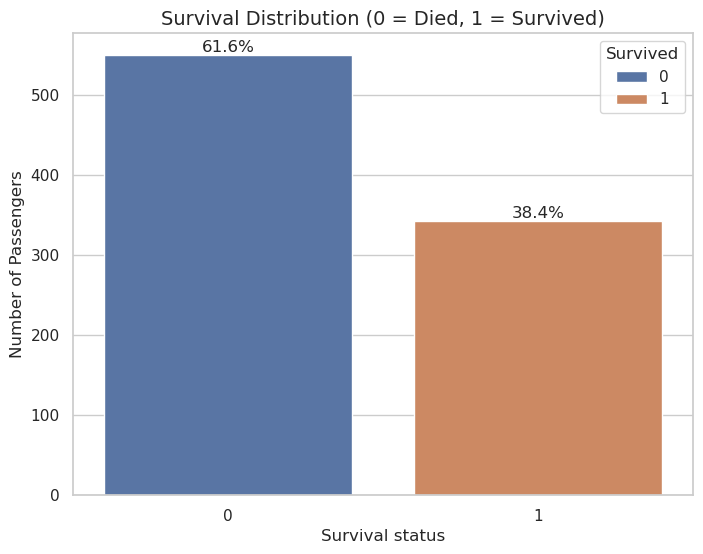

In [81]:
# A general config for all plots in the notebook --> To insure a consistent style
sns.set_theme(style='whitegrid')

# Create countplot for `Survived`
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df_train, x='Survived', hue='Survived')
plt.title('Survival Distribution (0 = Died, 1 = Survived)', fontsize=14)
plt.xlabel('Survival status', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)

# Add percentage bars on top for clarity
total =  len(df_train)
count = 0
for p in ax.patches:
    if p.get_height() > 0:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

# Show the final plot
plt.show()

**Observations from Countplot for `Survived` (`sns.countplot()`)**

---

A simple and direct plot for visualization of categorical variables.

*   **Imbalanced survival distribution**
    *   **Observation**: The plot confirms the classes are imbalanced. 38.4% percent of all passengers survive. Thus 61.6% do not.
    *   **Implication for modeling**: This imbalance is a crucial baseline. A naive model only predicting "Died" would have an accuracy of 61.6%. Therefore for our model to be useful it need to perform notably better then this baseline. 
    
    *   Furthermore, this imbalance means that accuracy alone is an insufficient metric. A superior assessment strategy would be to evaluate the model's performance on both "Died" and "Survived" classes separately. For this approach we will evaluate our models performance using **Precision**, **F1-score** and **Recall**. 

### 3.2 High-Level Feature Analysis and Selection

---

Before moving to further analysis we will do a pre-analysis screening of our features. The goal is to identify the most promising features to focus on for the rest of the EDA. 

This approach is more direct, but comes with its own drawbacks. This will be discussed in more detail at the end of this section.

#### 3.2.1  Screening Numerical Features with a Correlation Heatmap

--- 

To get abroad overview of the relationships in our data, we'll start by exploring linear-relationships between our numerical features and target variable, `Survived`.

To achieve this we will use a correlation heat-map.

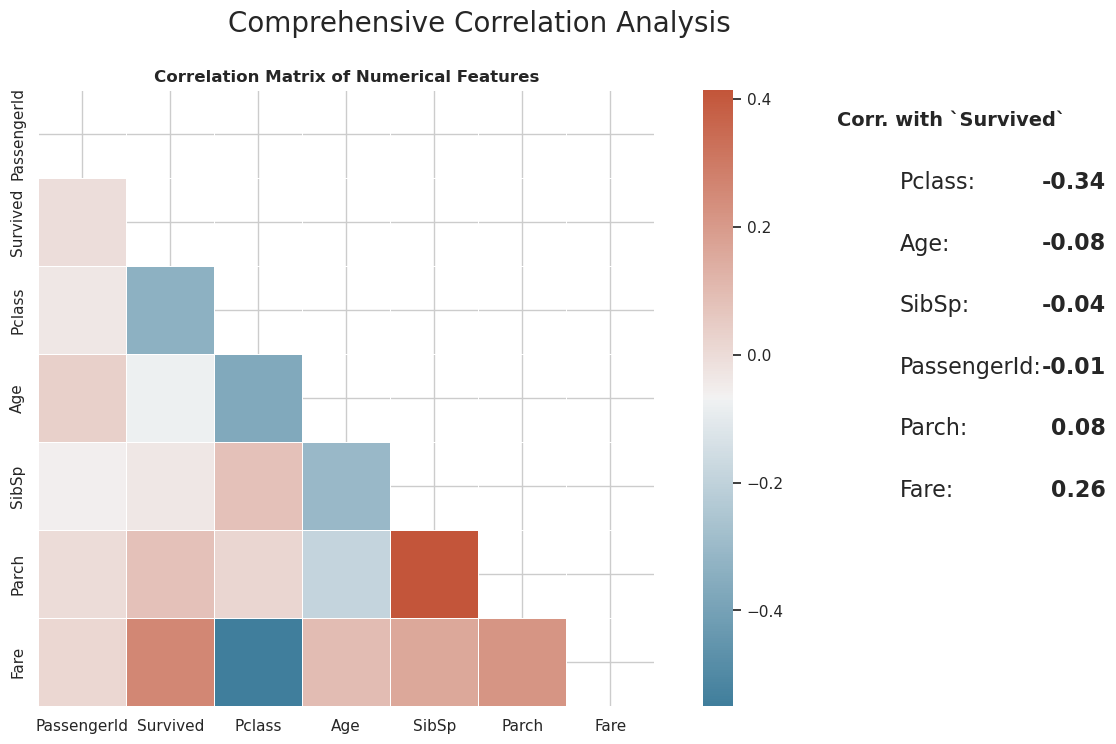

In [82]:
# Extract numerical features
df_numerical = df_train.select_dtypes(include=np.number)

# Compute correlation matrix
corr = df_numerical.corr()
# Correlation between target variable and numerical features
corr_to_survived = corr['Survived'].sort_values(ascending=True)

# Create base figure
fig = plt.figure(figsize=(16, 8))
# Define gridspec
grid_spec = gs.GridSpec(1, 3, width_ratios=[15, 2, 1], wspace=.1)

# Assign placement for heatmap and text column
ax_heatmap = fig.add_subplot(grid_spec[0, 0])
ax_text = fig.add_subplot(grid_spec[0, 1])

# Add mask for spacing
mask = np.triu(np.ones_like(corr, dtype=bool))
# Custom colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Initialize heatmap
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    annot=False, 
    square=True,
    linewidths=.5, 
    ax=ax_heatmap,
)

# Title for heatmap
ax_heatmap.set_title('Correlation Matrix of Numerical Features', fontweight='bold')
ax_text.axis('off')

# Labels for text column
text_labels = corr_to_survived.drop('Survived').index
text_values = corr_to_survived.drop('Survived').values

# Labels for text column
ax_text.text(.5, .95, 'Corr. with `Survived`', 
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=14, fontweight='bold'
             )

# Offset
vertical_offset = 0.85
# Loop through labels, and corr values
for label, value in zip(text_labels, text_values):
    text_to_display = f"{label}:"
    
    # Add labels to text column
    ax_text.text(0.1, vertical_offset, text_to_display, 
                 horizontalalignment='left', 
                 verticalalignment='center', 
                 fontsize=16)
    
    # Add values to text column
    ax_text.text(1.7, vertical_offset, f"{value:.2f}",
                 horizontalalignment='right',
                 verticalalignment='center',
                 fontsize=16, fontweight='bold')
    
    # Vertical offset
    vertical_offset -= 0.1

# Add subtitle for entire plot
plt.suptitle('Comprehensive Correlation Analysis', fontsize=20)
# Show the plot
plt.show()

**Observations from Correlation Analysis of Numerical Features:**

This visualization provides a clear overview of the linear relationship between the target variable and the numerical features. 

The heat-map on the left displays the Pearson correlation coefficient between all numerical features, including our target variable, `Survived`. The list to the right isolates the correlations between `Survived` and each feature.


---

*   **Key Findings:**
    *   **Strong Predictors (`Pclass` and `Fare`):** From the plot their are two features which differentiates themselves from the others. `PClass` and `Fare` both share a strong correlation with the target variable. 
        *   **`Pclass`:** Exhibits a strong negative correlation, with a coefficient value of **-0.34**. This indicates that passenger's with a lower class number (i.e., 1st Class) is associated a higher likelihood of survival, which aligns with rescue priorities.
        *   **`Fare`:** Shows the the strongest positive correlation of our numerical features, with a coefficient value of **0.26**.  This comes as no surprise as a higher `Fare` prize grants a lower class `Ticket`.
        
        **Weak Predictors (`Parch`, `Age` and `SibSp`):** The remaining features show a much weaker linear correlation to the target variable. 
        *   **`Parch`** shows as a mild positive correlation of 0.08.
        *   **`Age` and `SibSp`** have a near-zero linear correlation.

        **Important Non-Linear Indicator (`Age`):** The near-zero linear correlation between `Survived` and `Age` is unexpected, and counter intuitive. The relationship is probably non-linear, and could be explained by multiple hypothesis. As an example children and elderly might both have a higher priority. If this were the case, the opposite sides would counter act each other in a linear relationship. We will look into this further.

**Conclusion:**
Moving forward we will have a larger focus on `Pclass`, `Parch` and `Fare`. `Pclass` and `Fare` is the most prominent features so far with a clear linear relationship to `Survived`. We will also take a closer look to `Parch` and `Age` to see if their is a possibility to discover a stronger non linear relationship to the target variable.

#### 3.2.2 Screening Categorical Features with Bar Plots

---

A correlation heat-map is not suitable for categorical features. To screen these predictors, we will instead plot our categorical features against `Survived` using **bar plots**.

##### Analysis of `Sex` vs. `Survived

---

We begin our screening of categorical features with `Sex`. `Sex` is hypothesized to be one of the most predictive features in our dataset, and sets a good baseline for the rest of the screening. 
A bar plot is the most simple and direct way to visualize the two survival rates for male and female.

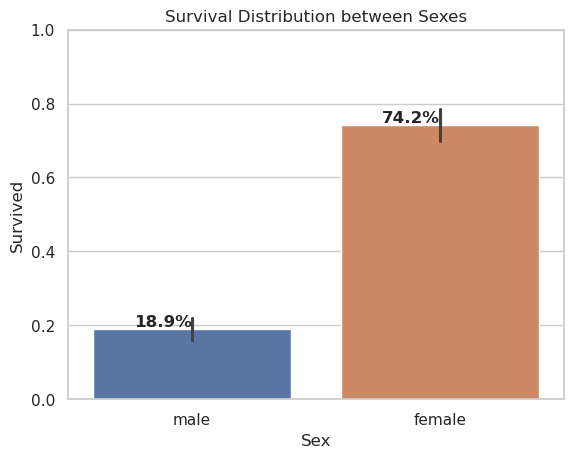

In [92]:
# Bar Plot for `Sex`
ax = sns.barplot(data=df_train, x='Sex', y='Survived', hue='Sex')

# Title
plt.title("Survival Distribution between Sexes")

ax.set_ylim(0, 1)

# Add percentage
total = len(df_train)
for p in ax.patches:
    if p.get_height() > 0:
        percentage = f'{p.get_height():.1%}'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(text=percentage, xy=(x,y), ha='right', va='bottom', fontsize=12, fontweight='bold')

plt.show()

**Observations from `Bar Plot` for `Sex` vs. `Survived`:**
*   **`Sex` as a Dominant Predictor:** The plot strongly confirms our previous hypothesis, with females having a survival rate of **74.2%**, compared to males **18.9%**. This massive disparity establishes `Sex` arguably as the biggest determinant for survival.

*   **Key Insight:** While `Sex` is a powerful predictor it alone does not account for the entire discrepancy, 25% of females do not survive and nearly 20% of males survive. This suggest that other factors still played a crucial role (e.g., `Pclass`, `Fare` and `Age`). 

A sufficient model must be able to distinguish which males and females survive separately to achieve the best results. Our primary concern forward will be to unwrap the factors which can differentiate survivors from non-survivors within each gender group.

##### Analysis of `Embarked` vs. `Survived

---

We will now explore the relationship between `Embarked` and `Survived`.

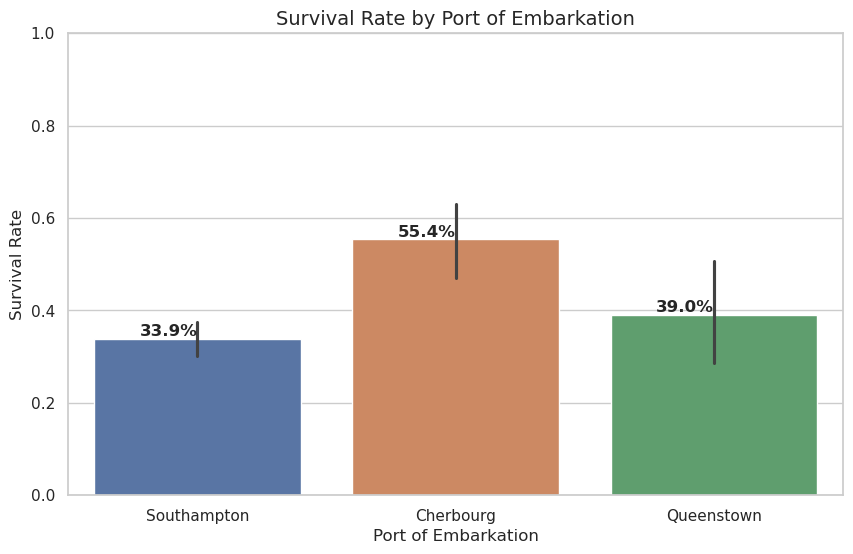

In [84]:
# Copy of dt_train
df_embarked_full_name = df_train.copy()

# Port dictionary
port_map = {'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'}

# Modified df_plot
df_embarked_full_name['Embarked_Full_Name'] = df_embarked_full_name['Embarked'].fillna('S').map(port_map)

# Create the plot
plt.figure(figsize=(10, 6)) 

# Bar Plot for `Embarked`
ax = sns.barplot(data=df_embarked_full_name, x='Embarked_Full_Name', y='Survived', hue='Embarked_Full_Name')

# Title
plt.title("Survival Rate by Port of Embarkation", fontsize=14)
# X-Label
plt.xlabel("Port of Embarkation", fontsize=12)
# Y-Label
plt.ylabel("Survival Rate", fontsize=12)
# Set y-limits
ax.set_ylim(0, 1)

# Add percentage
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        percentage = f'{height:.1%}' # Using the cleaner formatting
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        
        ax.annotate(text=percentage, xy=(x,y), ha='right', va='bottom', fontsize=12, fontweight='bold')

plt.show()

**Observation from `Bar Plot` for `Embarked` vs. `Survived`:**
*   **Key Differences between ports:**
    *   **Cherbourg:** Passengers from `Cherbourg` have a significantly higher survival rate **(55.4%)** than the two other ports. 
        **Southampton and Queenstown** have a fairly similar distribution with a survival rate of **33.9%** and **39.0%** respectively.

*   **Hypothesis: Embarked as a Proxy for Socioeconomic status**
    *   **Cherbourg has passengers with a higher fare and lower class:** A plausible explanation for this discrepancy is that passengers departing from `Cherbourg` were of higher class (i.e., lower `Pclass` number) than class then `Southampton` and `Queenstown`, and also paid a higher fare on average.
    *   **Validation:** We can validate this hypothesis using both by statistical test and visualization tools. 
        *   **Visualization:** We can use box plots to compare distributions for `Fare` and `Pclass` across `Embarked`. 
        *   **Statistical tests:**
            *   A **Chi-Squared** test is appropriate for `Embarked` and `Pclass` due to both being categorical variables.
            *   An **Anova** test is appropriate for `Embarked` and `Fare` to compare the mean across three categorical groups.

##### Validating the Embarked-Socioeconomic Hypothesis

---
 
Before moving on the **Summary** and **Deep-Dive** we will quickly validate the proposed hypothesis using the visualization tool mentioned above.

Let's create and analyze two box plots for comparing the distributions for `Fare` and `Pclass` across `Embarked`.

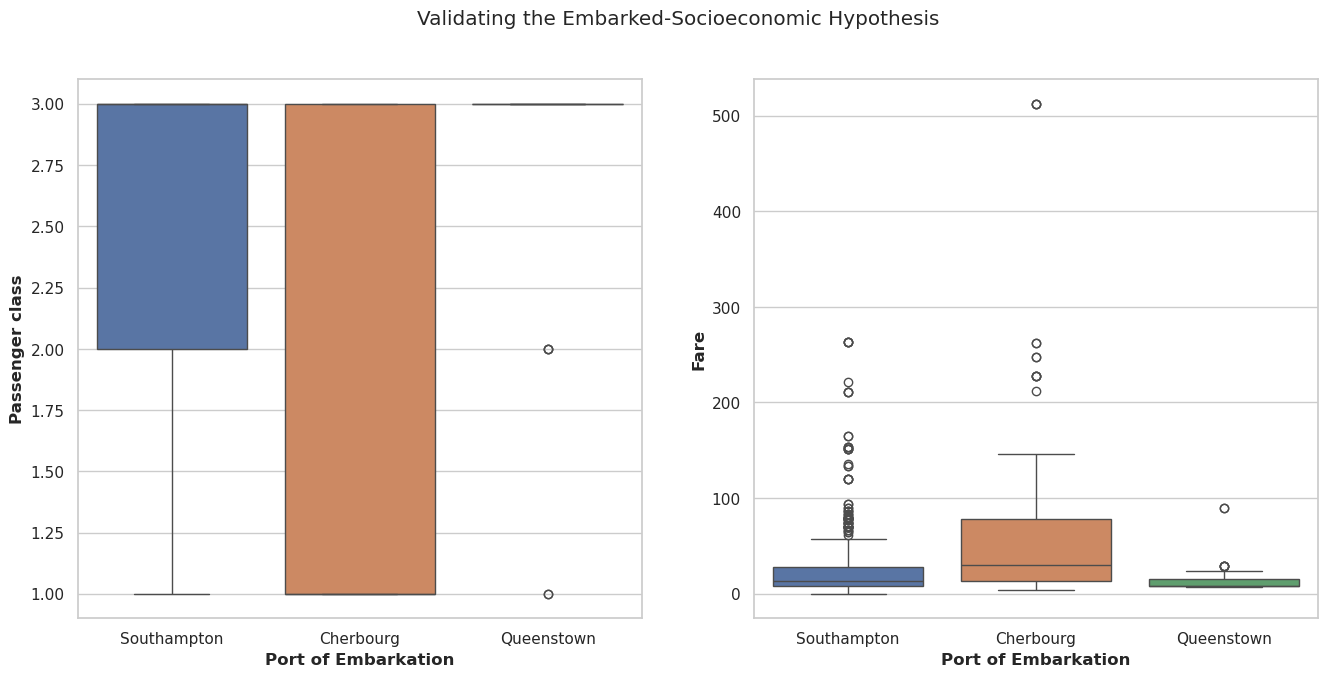

In [85]:
# Create figure along with axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Add headline for both plots
fig.suptitle('Validating the Embarked-Socioeconomic Hypothesis')

# Creating plot for `Pclass`
sns.boxplot(data=df_embarked_full_name, x='Embarked_Full_Name', y='Pclass', ax=ax1, hue='Embarked_Full_Name')
ax1.set_xlabel('Port of Embarkation', fontweight='bold')
ax1.set_ylabel('Passenger class', fontweight='bold')

# Creating plot for `Fare`
sns.boxplot(data=df_embarked_full_name, x='Embarked_Full_Name', y='Fare', ax=ax2, hue='Embarked_Full_Name')
ax2.set_xlabel('Port of Embarkation', fontweight='bold')
ax2.set_ylabel('Fare', fontweight='bold')

plt.show()

**Observations from `Box Plots` Validating the Embarked-Socioeconomic Hypothesis:**
*   **`Pclass` vs. `Embarked`:** As we expected passengers departing from Cherbourg had a lower `Pclass` than those from Southampton and Queenstown. Queenstown's passengers were almost entirely 3rd class passengers. Southampton shows a wider distribution, with a median of 2nd class. 
*   **`Fare`vs. `Embarked`:** The `Fare` plot provides further confirmation. The median fare for a Cherbourg passenger was substantially higher than for passengers from Southampton and Queenstown. Queenstown's passengers had the lowest median fare of the three groups. This directly mirrors the findings in the `Pclass` plot.

*   **Summary:** As expected from the hypothesis, `Fare` and `Pclass` both share a strong association to `Embarked`. Passengers departing from Cherbourg paid a higher fare while having a lower class, compared to Southampton and Queenstown.

#### 3.2.3 Summary of Screening and Selection for Deep Dive

---

Now that we have screened both numerical and categorical features, we can select the most promising candidates for further analysis. 

The screening process has clearly identified `Sex`, `PClass` and `Fare` as our most predictive features. In addition we will also include `Age` in our deep-dive. While it has a weak linear relationship we hypothesize it has a strong non-linear relationship to the target variable. We plan to uncover this possible relationship.

######

### 3.3 Deep-Dive Analysis of Key Features

--- 

In this section, we will perform a deep-dive analysis of key features identified in our screening: `Sex`, `Pclass`, `Fare` and `Age`.

For each feature we will conduct both a univariate analysis to understand the features distribution and a bivariate analysis to explore it's relationship to the target variable. 

#### 3.3.1 Analysis of `Sex`

---

As established in the initial screening, `Sex` is arguably the single most powerful predictor in the dataset. With females having a survival rate of **~74%** compared to just **~18%** for males. With this in mind, we will start our deep dive analysis with one of the most impactful features in our model.

Instead of repeating the bar plot showing the survival rate, we will now look at the **absolute counts** of survivors and non-survivors for each sex. This will give us a better understanding of the relationship between females and males, as well as the tragedy for each group.

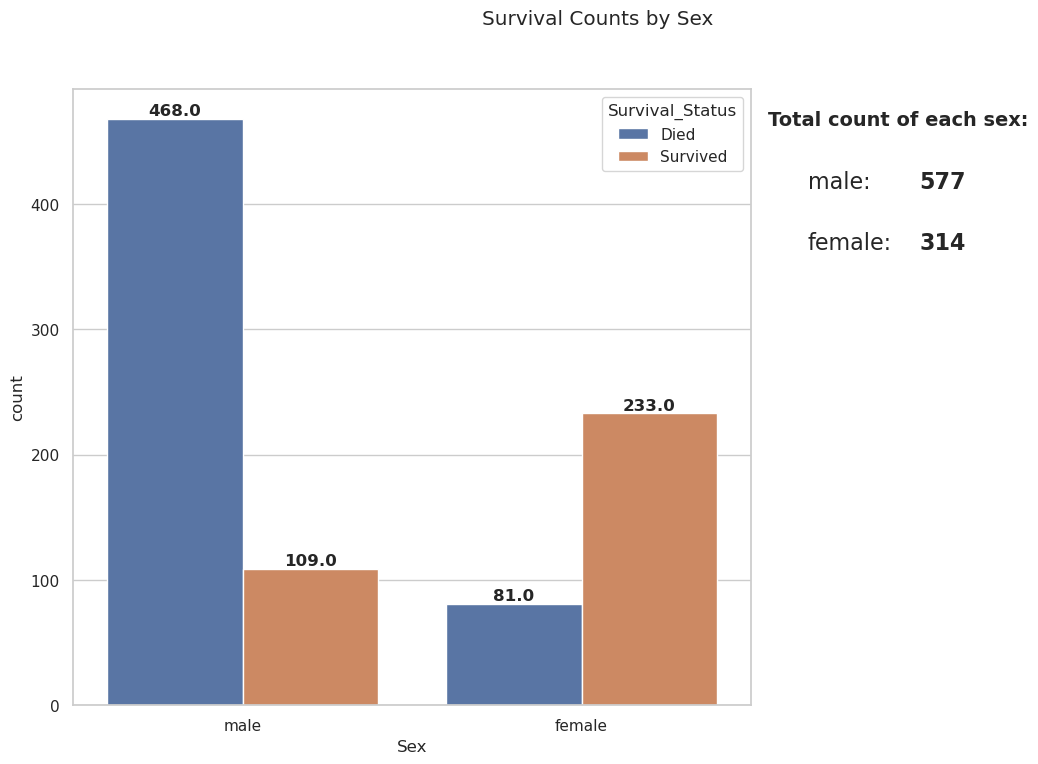

In [86]:
# Create a temporary copy for plotting
df_plot = df_train.copy()

# Map the 0 and 1 values to descriptive strings
df_plot['Survival_Status'] = df_plot['Survived'].map({0: 'Died', 1: 'Survived'})

# Create base figure
fig = plt.figure(figsize=(14, 8))

# Define gridspec
grid_spec = gs.GridSpec(1, 3, width_ratios=[6, 2, 1], wspace=.1) 

ax_countplot = fig.add_subplot(grid_spec[0,0])
ax_text = fig.add_subplot(grid_spec[0,1])

# Create both plots
sns.countplot(
    data=df_plot,
    x='Sex',
    hue='Survival_Status',
    ax=ax_countplot
)
ax_text.text(.5, .95, 'Total count of each sex:', 
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=14, fontweight='bold'
             )
ax_text.axis('off')

# Sex counts
sex_counts = df_train['Sex'].value_counts()
sex_types = df_train['Sex'].values

vertical_offset = 0.85
for label, value in sex_counts.items():
    text_to_display = f"{label}:"
    
    # Add labels to text column
    ax_text.text(0.1, vertical_offset, text_to_display, 
                 horizontalalignment='left', 
                 verticalalignment='center', 
                 fontsize=16)
    
    # Add values to text column
    ax_text.text(0.8, vertical_offset, f"{value}",
                 horizontalalignment='right',
                 verticalalignment='center',
                 fontsize=16, fontweight='bold')
    
    # Vertical offset
    vertical_offset -= 0.1

# Add counts to on top of bars on the count plot
for p in ax_countplot.patches:
    if p.get_height() > 0:
        count = f'{p.get_height()}'
        x = p.get_x() + p.get_width()  / 2
        y = p.get_height()
        ax_countplot.annotate(text=count, xy=(x, y), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.suptitle('Survival Counts by Sex')
plt.show()

**Observations from `Survival Counts by Sex`:**
*   **Population Imbalance:** Vastly more men than women were on the ship: **577 to 314**
*   **Disproportionate Male Fatalities:** The most harsh discovery so far, **468** males died in the tragic accident. The number outweighs female fatalities by almost sixfold (81 female non-survivors).
*   **Survival Priority Confirmed:** Despite males outnumbering females two to one, the number if female survivors (**233**) was more than double the number of male survivors (**109**). This confirms the previously established survival rates for women (**~74%**) and men (**~18%**), highlighting that sex was the single most critical factor in determining survival.

#### 3.3.2 Analysis of `Pclass`

---

The next feature to analyze is `Pclass`. As we discovered earlier, `Pclass` has the strongest linear relationship to `Survived` compared to all numerical features. Making it a natural follow-up to our analysis of `Sex`. 


First, we will visualize the distribution of passengers across the three classes in `Pclass` with a **countplot**. We will then use a **bar plot** to analyze the survival rate for each class.

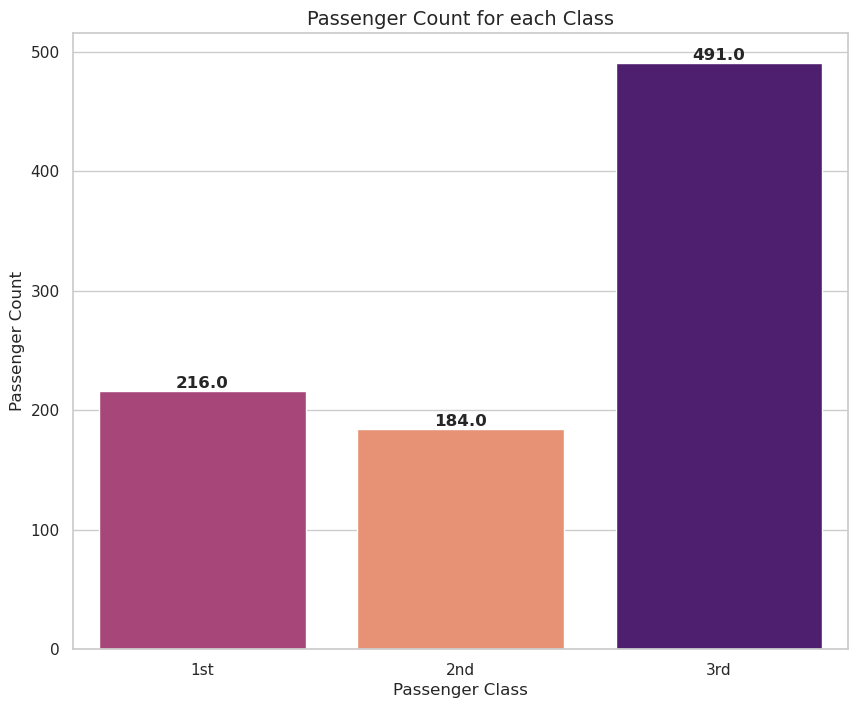

In [87]:
# Create a temporary copy for plotting
df_correct_class_names = df_train.copy()

# Map the 0 and 1 values to descriptive strings
df_correct_class_names['Passenger_Class'] = df_correct_class_names['Pclass'].map({1: '1st', 2: '2nd', 3: '3rd'})

# Create base figure
fig = plt.figure(figsize=(10, 8))

# Create both plots
ax = sns.countplot(
    data=df_correct_class_names,
    x='Passenger_Class',
    hue='Passenger_Class',
    order=['1st', '2nd', '3rd'],
    palette='magma',
    legend=False
)

# Add counts to on top of bars on the count plot
for p in ax.patches:
    if p.get_height() > 0:
        count = f'{p.get_height()}'
        x = p.get_x() + p.get_width()  / 2
        y = p.get_height()
        ax.annotate(text=count, xy=(x, y), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Passenger Count')
plt.xlabel('Passenger Class')
plt.title('Passenger Count for each Class', fontsize=14)
plt.show()

**Observations from `Passenger Count for each Class`:**

*   **`Population Imbalance`:** The 3rd class strongly outweighs the two other classes in terms of passengers. Its population (**491**) is more then the two other classes combined (**216** and **184**).
    *   **Problem:** When a category has a severe feature imbalance, this can introduce unwanted biases. This is especially apparent when dealing with models which struggles to cope with disproportionately represented groups. KNN-model is included in this group. For model's with good bias handling like gradient approaches the problem still becomes visible during evaluation of the model.
    *   **Strategy:** During model evaluation, we will use **Stratified Cross-Validation** to ensure each passenger class is represented proportionally in both training and validation. This approach creates a more robust and reliable measure of the model's performance across all groups.
    *   **Extra (Feature Engineering Strategy):** We will engineer and test a new feature `Survival_Rate_For_Passenger's_Class`. This feature will encode the survival probability for each passenger's class.
        *   **Leakage Prevention:** To avoid any data leakage, these survival rates will be calculated exclusively from the `df_train` dataset, excluding the passenger itself.

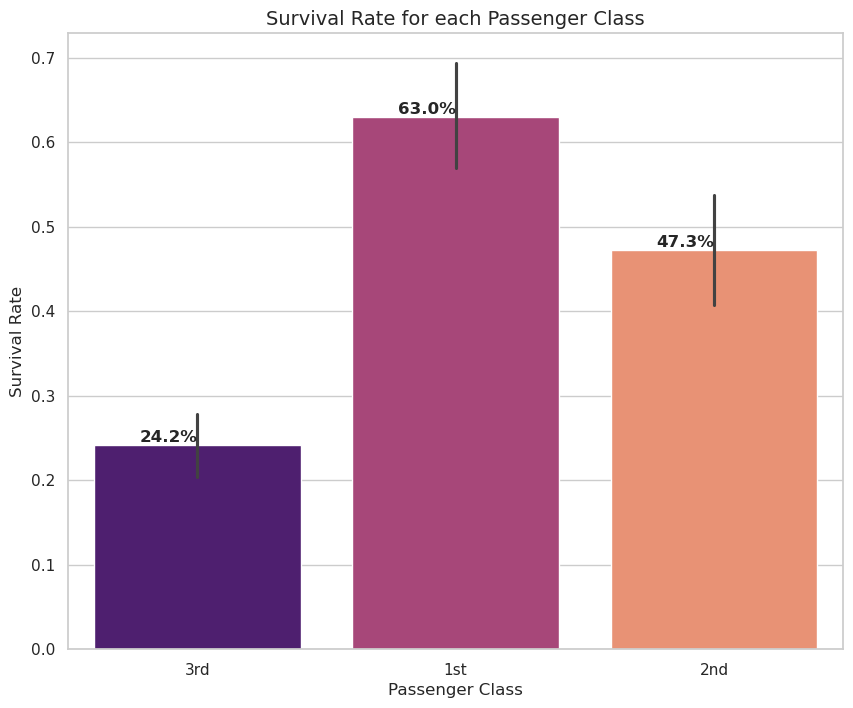

In [90]:
# Make plot for bivariate analysis of `Pclass`
# Create figure
fig = plt.figure(figsize=(10, 8))

# Init plot -- We will use a barplot
ax = sns.barplot(data=df_correct_class_names, x='Passenger_Class', y='Survived', hue='Passenger_Class', palette='magma')

# Add percentages
total = len(df_correct_class_names)
for p in ax.patches:
    if p.get_height() > 0:
        percentage = f'{p.get_height():.1%}'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(text=percentage, fontweight='bold', xy=(x, y), ha='right', va='bottom')

plt.ylabel('Survival Rate')
plt.title('Survival Rate for each Passenger Class', fontsize=14)
plt.xlabel('Passenger Class')

plt.show()

**Observations from `Survival Rate for each Passenger Class`:**
*   **Survival Rate Imbalance:** As the figure shows, passengers from the 1st class had a significantly higher survival rate (**63.0%**) compared to the other two classes (**47.3** for 2nd and **24.2%** for 3rd).
    **Feature Engineering:** This strong imbalance between classes reinforces the proposed strategy of engineering a new feature, `Pclass_Survival_Rate`. By directly encoding the survival probability we ensure that even the simpler models are able to utilize and detect the clear pattern. Not leveraging this clear relationship would be a missed opportunity.

#### 3.3.3 Analysis of `Fare`

--- 

The last feature with a clear linear correlation to the target variable. We will go through the same steps as for the two previous features.
 
Before moving it is important to note that in contrast to `Sex` and `Pclass`, `Fare` is a numerical feature, this requires us to choose different visualization tools.

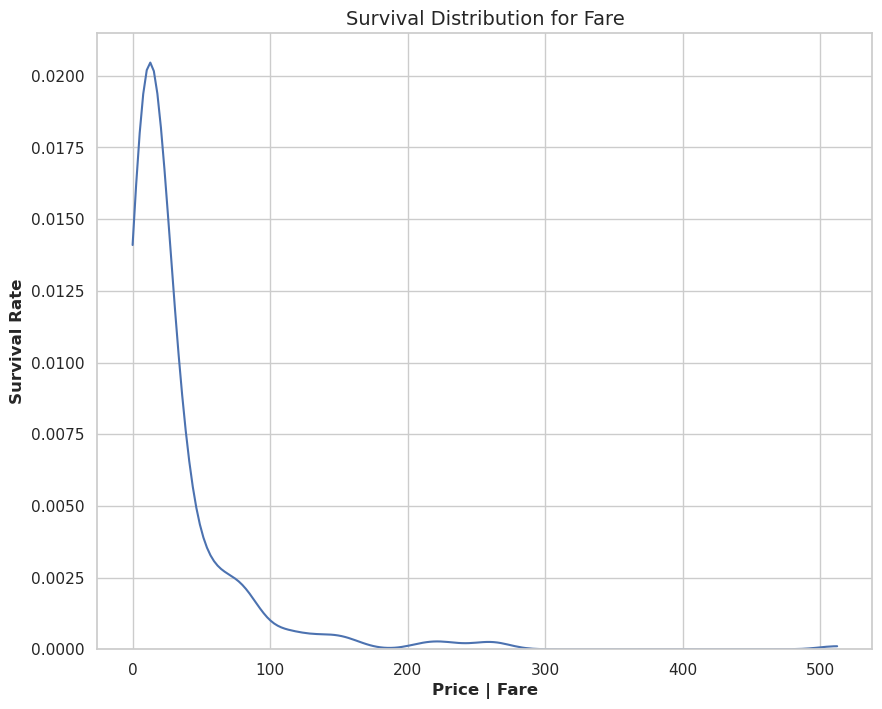

In [111]:
# Make plot for univariate analysis of `Fare`
# Create figure
fig = plt.figure(figsize=(10, 8))

# Init plot -- We will use a kdeplot
ax = sns.kdeplot(data=df_train, x='Fare', cut=0)


plt.ylabel('Survival Rate', fontweight='bold')
plt.title('Survival Distribution for Fare', fontsize=14)
plt.xlabel('Price | Fare', fontweight='bold')

plt.show()

**Observations from `Survival Distribution for Fare`:**
*   **Strong Outliers:** In the start of the second section in this notebook, we discovered that `Fare` had very high maximum compared to the 75% quantile. Our visualization plot confirms our previous assumption.
    *   **Problem:** Such a skewed distribution with extreme outliers can be problematic for certain models, particularly linear models (like logistic regression) and distance-based models (like KNN). These models can be disproportionately influenced by the magnitude of outliers. 
    *   **Strategy:** A standard approach for right-skewed financial data is using logarithmic-transformation. The process if fairly simple, we just take the natural logarithm (we use log1p, so we do not need to worry of log0) of each value, swapping the original value with the transformed value.

* **Note:** It is possible to hypothesize if `Fare` proposes any real value to the model. `Fare` is a good indicator for class and therefore will be a predictive value. However that may be the only reason for its predictive ability, if that is the case, dropping the column might be beneficial. It would simplify the model, and could prevent noise. We will test this further in the modelling section. `Fare` might have an underlying relationship to the target variable we are unaware off.

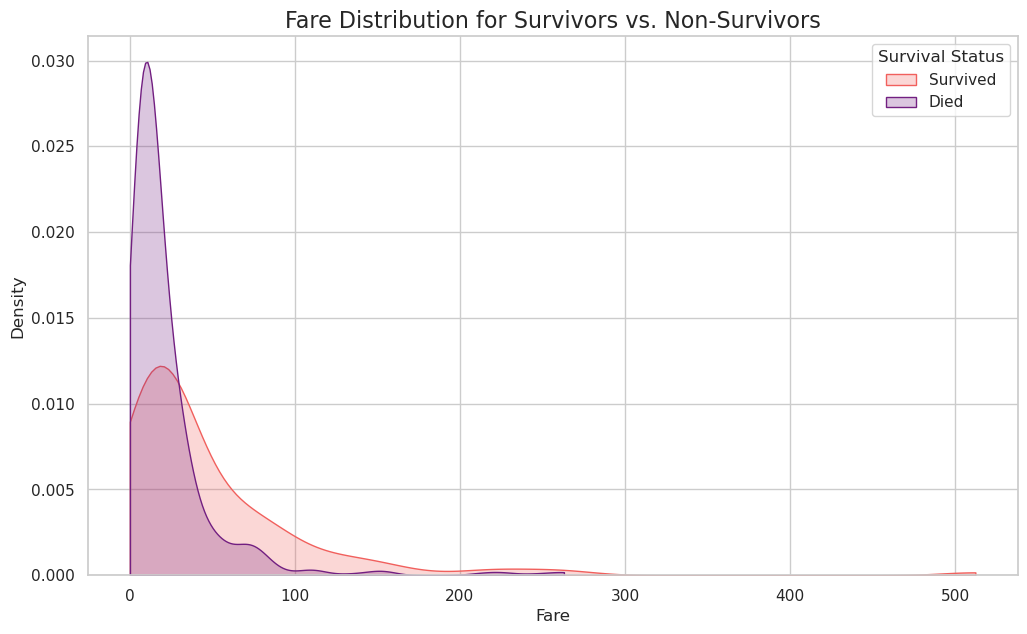

In [110]:
# Create figure
plt.figure(figsize=(12, 7)) # Litt bredere er ofte bedre for dette

# Init plot -- 1D kdeplot with 'hue'
ax = sns.kdeplot(
    data=df_train, 
    x='Fare',          
    hue='Survived',   
    fill=True,        
    common_norm=False,
    palette='magma',
    cut=0   
)

# Title and labels
plt.title('Fare Distribution for Survivors vs. Non-Survivors', fontsize=16)
plt.xlabel('Fare')
plt.ylabel('Density') 

plt.legend(title='Survival Status', labels=['Survived', 'Died']) 

plt.show()

**Observations `Fare Distribution for Survivors vs. None-Survivors`:**
*   **Key Differences Between Surviors and Non-Survivors:**
    *   The distribution for **non-survivors** are very concentrated around the mode.
    *   In contrast, the distribution for **survivors are much more spread out**, consequently with a substantially higher variance. In addition the **survivors** had a slightly higher mean.
*   **Conclusion:** The figure confirms what we already now about the structure of our data.

**Testing the `Fare` vs. `Pclass` Hypothesis:**
*   **Previous Hypothesis:** In the analysis above I hypothesized if `Fare` was only a predictor due to indicating `Pclass`. In other words `Pclass` determines survival rate, while `Fare` only indicates `Pclass`.
*   **Limitation of Current Plot:** Since our figure only displays the relationship between `Fare` and `Survived`, it cannot answer the hypothesis.
*   **Strategy:** To investigate this, we will conduct one more visualization that explores the relationship between `Fare` and `Survived` separately for each `Pclass`.

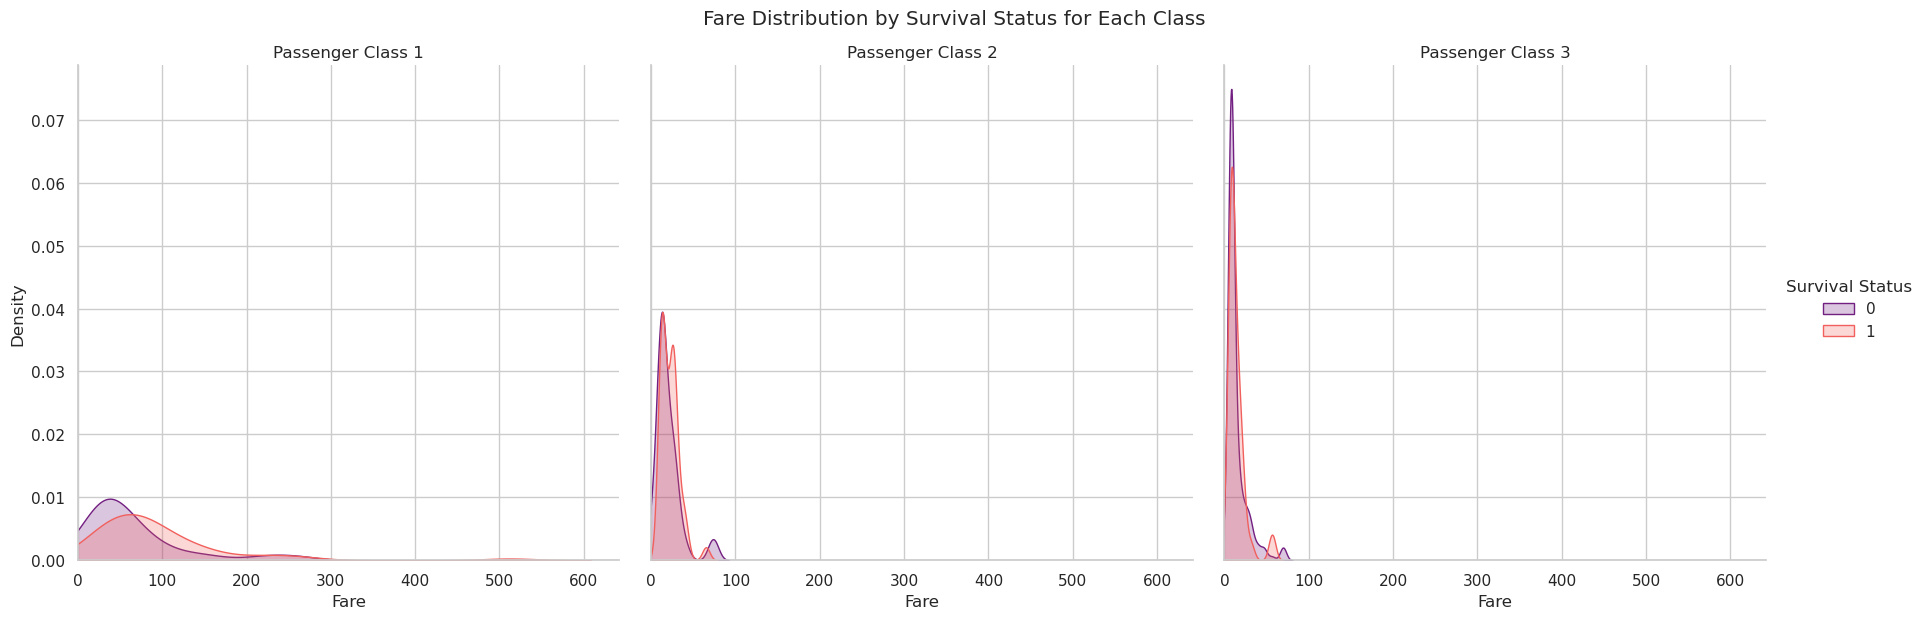

In [ ]:
# Multivariate Analysis of `Fare` `Survived` and `Pclass`
g = sns.FacetGrid(df_train, col='Pclass', hue='Survived', height=6, aspect=1, palette='magma')

g.map(sns.kdeplot, 'Fare', fill=True, common_norm=False)

g.set_axis_labels('Fare', 'Density')
g.set_titles('Passenger Class {col_name}')
g.add_legend(title='Survival Status')
g.set(xlim=(0, None))

g.figure.suptitle('Fare Distribution by Survival Status for Each Class', y=1.03) 
plt.show()


**Note:** This plot shows the full distribution for all classes. In its current state it is hard too properly see the traits of each distribution. We will therefore set the right x-limit to 300. 

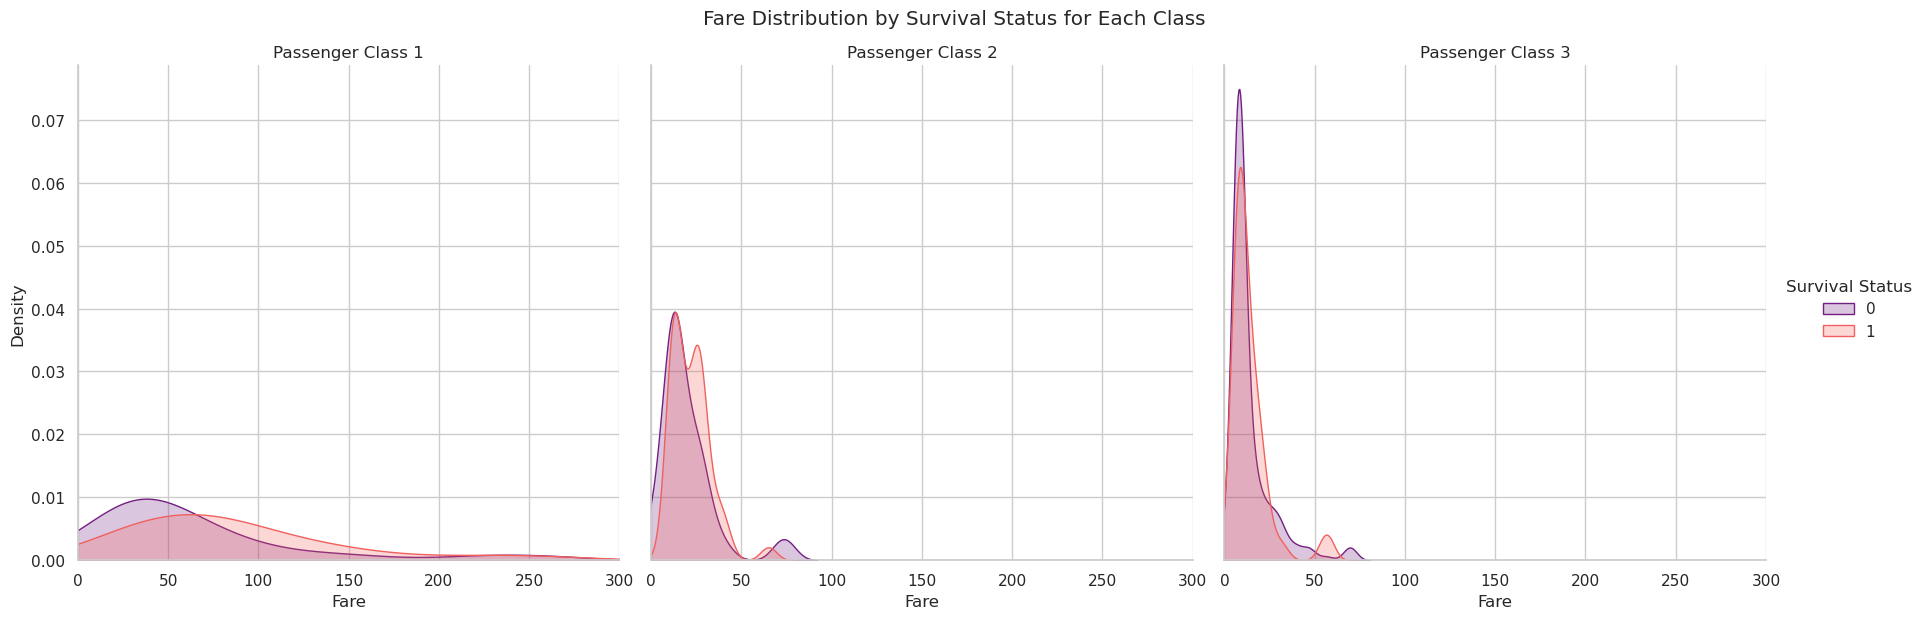

In [ ]:
# Multivariate Analysis of `Fare` `Survived` and `Pclass`
g = sns.FacetGrid(df_train, col='Pclass', hue='Survived', height=6, aspect=1, palette='magma')

g.map(sns.kdeplot, 'Fare', fill=True, common_norm=False)

g.set_axis_labels('Fare', 'Density')
g.set_titles('Passenger Class {col_name}')
g.add_legend(title='Survival Status')
g.set(xlim=(0, 300))

g.figure.suptitle('Fare Distribution by Survival Status for Each Class', y=1.03) 
plt.show()

**Testing the `Fare` vs. `Pclass` Hypothesis:** This faceted plot allows us to test our key hypothesis: is `Fare` distributions only a predictor because it indicates `Pclass`, or does it have its own predictive value?

**Observations `Fare Distribution by Survival Status for Each Class`:**
*   **For 2nd 3rd Class, `Fare` has little to no impact:** In the plots for both 2nd and 3rd class, the distributions for survivors and non-survivors are almost identical. Indicating that the fare prize has no-value for survival rate. 
*   **For 1st Class, `Fare` may have a predictive value:** The plot for 1st class, are not as identical for survivors and non-survivors. It is completely possible that this distinction is due to natural variance, especially as we discoverd that the 1st class has substantially less passengers then the two other classes. 
*   **Approach for 1st Class Problem:** As the visualization left us unsure, we will quickly perform a **two-sample Kolmogrov-Smirnov (KS) test**. This test will determine if the difference between `Fare` distributions for survivors and non-survivors is statistically significant. We will use a significance level of 5% to reject or accept the nullhypothesis.

In [156]:
# Load imports for statistical tests
from scipy.stats import ks_2samp
# Perform the two-sample KS test
ks_statistic, p_value = ks_2samp(fare_survived, fare_died)

# Print the result in a user-friendly way
print(f"KS Test for Pclass 1 Fare distributions (Survivors vs. Non-survivors):")
print(f"  P-value: {p_value:.7f}")

# Interpret the result based on a 5% significance level
alpha = 0.05
if p_value < alpha:
    print(f"  Conclusion: Since the p-value is less than {alpha}, we reject the null hypothesis.")
    print("  There is a statistically significant difference between the two distributions.")
else:
    print(f"  Conclusion: Since the p-value is greater than {alpha}, we fail to reject the null hypothesis.")
    print("  There is no statistically significant difference between the two distributions.")

KS Test for Pclass 1 Fare distributions (Survivors vs. Non-survivors):
  P-value: 0.0000304
  Conclusion: Since the p-value is less than 0.05, we reject the null hypothesis.
  There is a statistically significant difference between the two distributions.


**Final Conclusion of `Fare`:**

Our analysis, confirmed by a KS-test, shows that `Fare` has a significant impact on the survival rate for `1st Class` passengers. `Fare` is therefore not just a indicator for `Pclass` but has its own predictive value. We will therefore not drop the column in the final model.

#### 3.3.4 Analysis of `Age`

---

The last part of this section before we move on to the summary, and feature engineering in the next notebook `01_feature_engineering.ipynb`.

Contrary to the other features in the deep-dive analysis, `Age` does not have a linear or associative relationship with `Survived`. Despite this I have chose to include it, because of my earlier hypothesis that `Age` might have an underlying relationship to the target variable that our correlation heatmap was not able to discover. 

Text(0.5, 1.0, 'Age Distribution among Passengers')

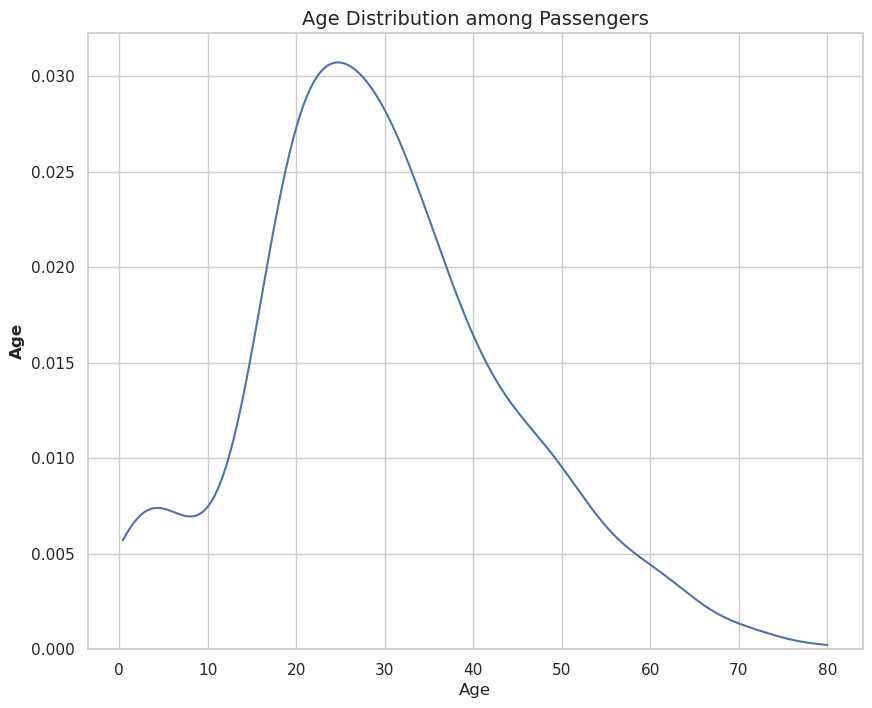

In [171]:
# Count Plot of `Age`
fig = plt.figure(figsize=(10, 8))
sns.kdeplot(data=df_train, x='Age', cut=0)
plt.ylabel('Age', fontweight='bold')
plt.title('Age Distribution among Passengers', fontsize=14)

**Observation of `Age Distribution among Passengers`:**
*   **Right-Skewed:** The distribution is right-skewed as expected, no passenger can be less than zero years old, however there are no direct upper age limit where the number of passengers goes to zero.

We will now move on to the most exiting part of the `Age` analysis. Trying to find a underlying or hidden relationship between `Age` and `Survived`. I hypothesized that the reason to why we were unable to find a linear correlation between `Age` and our target variable was due to both **children** and **elderly** being prioritized. If that were the case, both end sides of the **Survival Distribution of Age** would cancel themselves out. 

I think you can guess what the next visualization will be. A **KDE-Plot** with **Age** as a variable for **Survival Rate**. If we can see a clear distinction in survival rate dependent on age, we know `Age` has some underlying relationship to `Survived`. In other words, as long as the distribution is not **Uniform-Distribution** we can safely say age is a predictive feature for `Survival`.

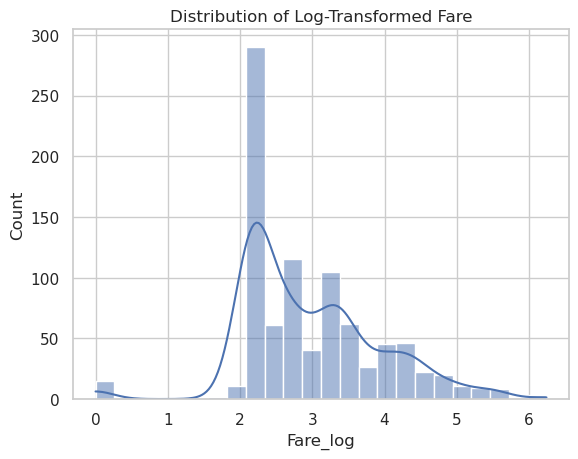

In [112]:
# Legg til 1 for å unngå log(0)
df_train['Fare_log'] = np.log1p(df_train['Fare'])

sns.histplot(df_train['Fare_log'], kde=True)
plt.title('Distribution of Log-Transformed Fare')
plt.show()

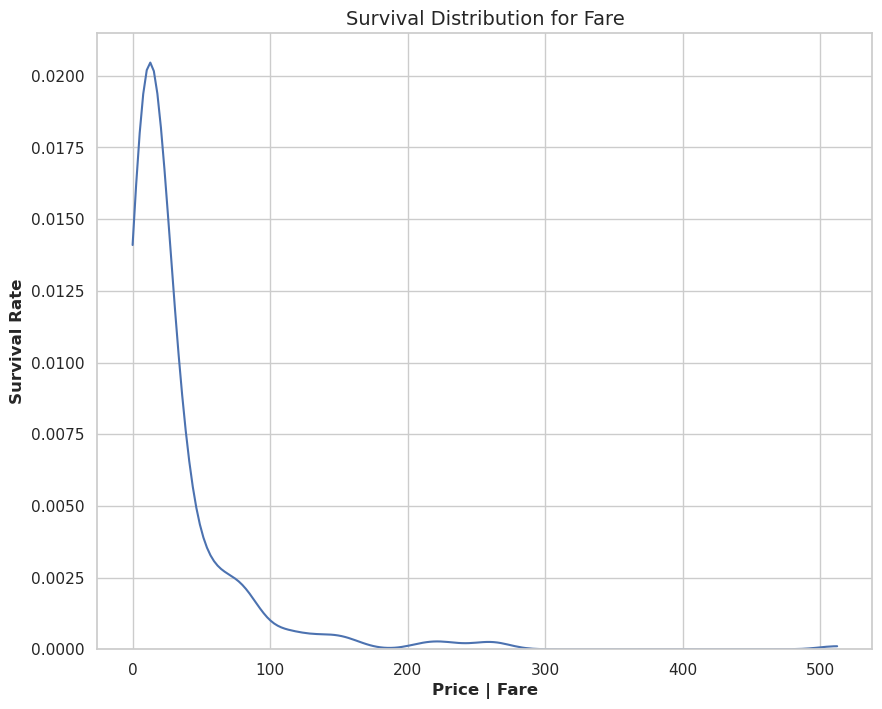

In [ ]:
# Make plot for univariate analysis of `Fare`
# Create figure
fig = plt.figure(figsize=(10, 8))

# Init plot -- We will use a kdeplot
ax = sns.kdeplot(data=df_train, x='Fare', cut=0)


plt.ylabel('Survival Rate', fontweight='bold')
plt.title('Survival Distribution for Fare', fontsize=14)
plt.xlabel('Price | Fare', fontweight='bold')

plt.show()

In [89]:
# Define features 
features = df_train.columns.drop(['Survived', 'PassengerId'])
# `print()` to verify
print(features)

# Data frame only including features and target
df_plot = df_train[['Survived'] + list(features)]
# `.head()` to verify
df_plot.head()

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
